# Sequence-Dependent Setup Times

This example adds setup times between tasks based on their product type.


## Problem Description

Sequence-dependent setup times occur when switching between different
product types on a machine. Each task has a type, and setup time depends
on the type transition.

Objective: minimize makespan.


## Mathematical Model

Definitions:
$$
I_i: \text{task interval}, \quad t_i: \text{type}, \quad S: \text{setup matrix}
$$

Constraints:
$$
\text{NoOverlap}(\{ I_i \})
$$
$$
start_j \ge end_i + S_{t_i,t_j} \quad \text{if } i \text{ precedes } j
$$

Objective:
$$
\min \max_i end_i
$$


## Imports


In [1]:
# Imports
from pycsp3 import *
from pycsp3_scheduling import *  

## Problem Data


In [2]:
# Setup time matrix: setup[from_type][to_type]
setup_times = TransitionMatrix([
    [0, 5, 3],
    [4, 0, 6],
    [3, 6, 0],
])

tasks_with_types = [
    ('task1', 10, 0),
    ('task2', 8, 1),
    ('task3', 12, 0),
    ('task4', 6, 2),
    ('task5', 9, 1),
]

durations = [d for _, d, _ in tasks_with_types]
max_setup = max(max(row) for row in setup_times.matrix)
horizon = sum(durations) + max_setup * (len(tasks_with_types) - 1)


## Build the Model


In [3]:
clear()
from pycsp3_scheduling.variables.interval import clear_interval_registry

clear_interval_registry()

task_intervals = []
task_types = []
for name, duration, product_type in tasks_with_types:
    iv = IntervalVar(
        start=(0, horizon),
        end=(0, horizon),
        size=duration,
        name=name
    )
    task_intervals.append(iv)
    task_types.append(product_type)

sequence = SequenceVar(intervals=task_intervals, types=task_types, name="machine0")
satisfy(SeqNoOverlap(sequence, transition_matrix=setup_times.matrix))


noOverlap(origins:[iv_s_0, iv_s_1, iv_s_2, iv_s_3, iv_s_4], lengths:[10, 8, 12, 6, 9])
intension(function:or(le(add(iv_s_0,15),iv_s_1),le(add(iv_s_1,8),iv_s_0)))
intension(function:or(le(add(iv_s_0,13),iv_s_3),le(add(iv_s_3,6),iv_s_0)))
intension(function:or(le(add(iv_s_0,15),iv_s_4),le(add(iv_s_4,9),iv_s_0)))
intension(function:or(le(add(iv_s_1,12),iv_s_0),le(add(iv_s_0,10),iv_s_1)))
intension(function:or(le(add(iv_s_1,12),iv_s_2),le(add(iv_s_2,12),iv_s_1)))
intension(function:or(le(add(iv_s_1,14),iv_s_3),le(add(iv_s_3,6),iv_s_1)))
intension(function:or(le(add(iv_s_2,17),iv_s_1),le(add(iv_s_1,8),iv_s_2)))
intension(function:or(le(add(iv_s_2,15),iv_s_3),le(add(iv_s_3,6),iv_s_2)))
intension(function:or(le(add(iv_s_2,17),iv_s_4),le(add(iv_s_4,9),iv_s_2)))
intension(function:or(le(add(iv_s_3,9),iv_s_0),le(add(iv_s_0,10),iv_s_3)))
intension(function:or(le(add(iv_s_3,12),iv_s_1),le(add(iv_s_1,8),iv_s_3)))
intension(function:or(le(add(iv_s_3,9),iv_s_2),le(add(iv_s_2,12),iv_s_3)))
intension(f

In [4]:
objective_expr = Maximum(end_time(iv) for iv in task_intervals)
minimize(objective_expr)


## Solve


In [5]:
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found." + (" (Optimal)" if result == OPTIMUM else ""))
    schedule = []
    for iv in task_intervals:
        val = interval_value(iv)
        schedule.append((val.start, val.end, iv.name))
    schedule.sort()
    for start, end, name in schedule:
        print(f"{name}: [{start}, {end})")
    makespan = max(interval_value(iv).end for iv in task_intervals)
    print(f"Makespan: {makespan}")
else:
    print("No solution found.")


Solution found. (Optimal)
task5: [0, 9)
task2: [9, 17)
task1: [21, 31)
task3: [31, 43)
task4: [46, 52)
Makespan: 52


## Stats


In [6]:
print("Model statistics:", model_statistics())
if result in (SAT, OPTIMUM):
    objective_value = globals().get("makespan")
    print("Solution statistics:", solution_statistics(status=result, objective=objective_value))


Model statistics: ModelStatistics(nb_interval_vars=5, nb_optional_interval_vars=0, nb_sequences=1, nb_sequences_with_types=1, nb_cumul_functions=0, nb_state_functions=0)
Solution statistics: SolutionStatistics(status=OPTIMUM, objective_value=52, solve_time=None, nb_interval_vars=5, nb_intervals_present=5, nb_intervals_absent=0, min_start=0, max_end=52, makespan=52, span=52)


## Visualization


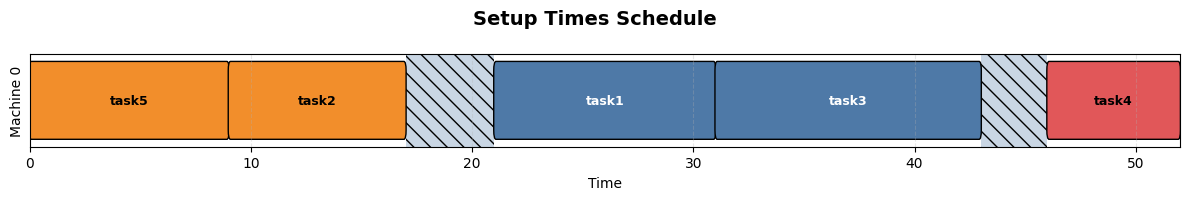

In [7]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(iv).end for iv in task_intervals)
    visu.timeline("Setup Times Schedule", origin=0, horizon=makespan)
    visu.panel("Machine 0")

    schedule = []
    for iv, t in zip(task_intervals, task_types):
        val = interval_value(iv)
        schedule.append((val.start, val.end, iv.name, t))
    schedule.sort()

    prev_end = None
    for start, end, name, t in schedule:
        if prev_end is not None and start > prev_end:
            visu.transition(prev_end, start, name="setup")
        visu.interval(start, end, name, color=t)
        prev_end = end

    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available).")
